In [ ]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [ ]:
tf.__version__

'2.14.0'

#**Create dataset**

In [ ]:
# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 10000
dt = 0.01

# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt

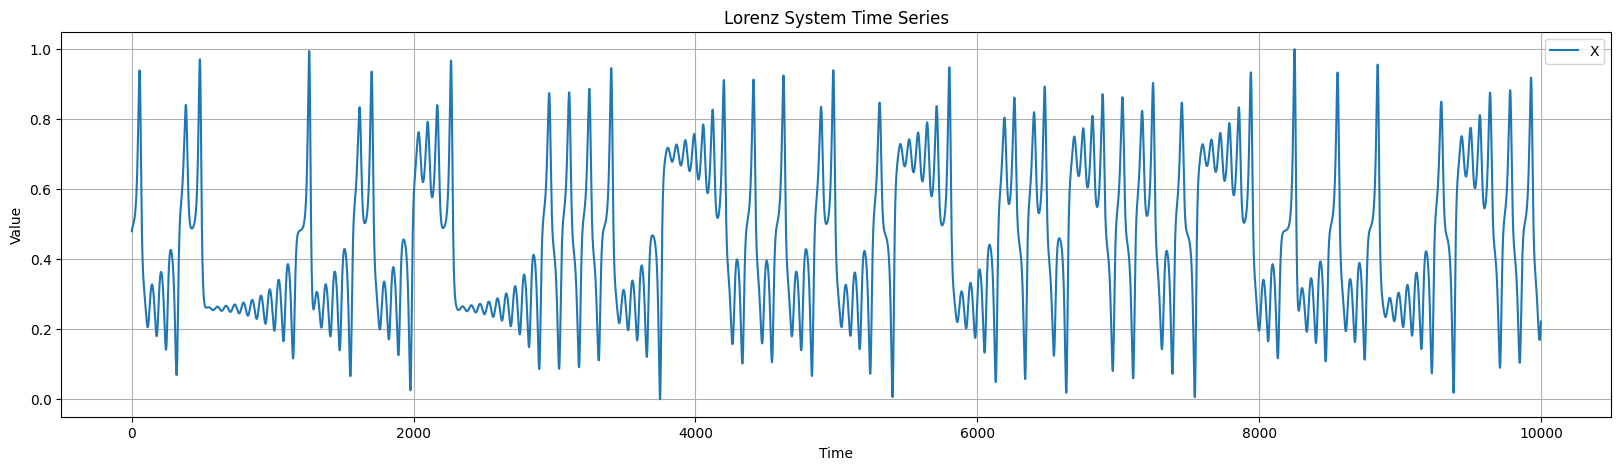

In [ ]:
timeserie = x

# Normalization
timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))

plt.figure(figsize=(20, 5))
plt.plot(timeserieNormalized, label='X')
plt.title('Lorenz System Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window = 30

X = np.zeros([len(timeserieNormalized)-window, window])
for i in range(len(timeserieNormalized)-window):
  X[i,:] = timeserieNormalized[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeserieNormalized[window:]

X = X[:,:, np.newaxis]

X.shape, y.shape


((9970, 30, 1), (9970,))

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape


((6380, 30, 1), (6380,), (1596, 30, 1), (1596,), (1994, 30, 1), (1994,))

#**Example convolutional**

##**TensorFlow**

**Input**


$$(samples, \; window \; size, 1 )$$

In [ ]:
data = X_train[0][np.newaxis,:,:]
data.shape

(1, 30, 1)

**Convolutional operation**

$$(kernel \; size, \; 1, \; \; output \; dimension )$$

In [ ]:
kernel_size = 5
output_dim = 100 # output_dim == D

kernel = np.ones([kernel_size, 1, output_dim], dtype=np.float32)
kernel.shape

(5, 1, 100)

In [ ]:
data = tf.convert_to_tensor(data, dtype=tf.float32)
kernel = tf.convert_to_tensor(kernel)

data.shape, kernel.shape

(TensorShape([1, 30, 1]), TensorShape([5, 1, 100]))

**Kernel bandwidth $(σ)$**

$$kernel \; scale = \sqrt{ \frac{(input \; dimension).(kernel \; size)^2}{2}} $$

$kernel \; scale$ is a trainable parameter

$$σ = \frac{1}{kernel \; scale}$$


In [ ]:
input_dim = 1

kernel_scale = np.sqrt((input_dim*kernel_size**2)/2.0)

scale = 1/kernel_scale

print("scale: ", kernel_scale)
print("Kernel bandwidth: ", scale)


scale:  3.5355339059327378
Kernel bandwidth:  0.282842712474619


In [ ]:
kernel = tf.math.multiply(scale, kernel)
kernel.shape

TensorShape([5, 1, 100])

In [ ]:
outputs = tf.nn.conv1d(data, kernel, stride=1, padding='VALID')
bias = tf.constant(np.random.rand(1), dtype=tf.float32)

outputs.shape

TensorShape([1, 26, 100])

$$z(\textbf{x}) = \sqrt{\frac{2}{D}} \left[ \cos{w_1^{⊤}\textbf{x}+b_1}, \cos{w_2^{⊤}\textbf{x}+b_2}, ̇\dots, \cos{w_D^{⊤}\textbf{x} + b_D} \right] $$

In [ ]:
RFF_COS_TF = tf.math.multiply(tf.math.sqrt(2/output_dim), tf.cos(outputs))

RFF_COS_TF.shape

TensorShape([1, 26, 100])

**On the Error of Random Fourier Features**

$$
z(\textbf{x}) = \sqrt{\frac{2}{D}} \begin{bmatrix}
\sin{w_1 \textbf{x}}
\\
\cos{w_1 \textbf{x}}
\\
\vdots
\\
\sin{w_1 \textbf{x}}
\\
\cos{w_1 \textbf{x}}
\end{bmatrix}
$$

In [ ]:
RFF_SIN_TF = tf.where(tf.equal(tf.math.mod(outputs, 2), 0),
                   tf.math.multiply(tf.math.sqrt(2/output_dim), tf.cos(outputs)),
                   tf.math.multiply(tf.math.sqrt(2/output_dim), tf.sin(outputs)))

RFF_SIN_TF.shape

TensorShape([1, 26, 100])

##**Pytorch**

**Input**


$$(samples, \; window \; size, 1 )$$

In [ ]:
data = X_train[0][np.newaxis, :, :]
data = torch.tensor(data, dtype=torch.float32).reshape(1, 1, 30)
data.shape

torch.Size([1, 1, 30])

**Convolutional operation**

$$(kernel \; size, \; 1, \; \; output \; dimension )$$

In [ ]:
kernel = torch.ones((output_dim, 1, kernel_size), dtype=torch.float32)

data.shape, kernel.shape

(torch.Size([1, 1, 30]), torch.Size([100, 1, 5]))

**Kernel bandwidth $(σ)$**

$$kernel \; scale = \sqrt{ \frac{(input \; dimension).(kernel \; size)^2}{2}} $$

$kernel \; scale$ is a trainable parameter

$$σ = \frac{1}{kernel \; scale}$$


In [ ]:
kernel_scale = torch.sqrt(torch.tensor((input_dim * kernel_size**2) / 2.0, dtype=torch.float32))
scale = 1 / kernel_scale

print("scale: ", kernel_scale)
print("Kernel bandwidth: ", scale)

scale:  tensor(3.5355)
Kernel bandwidth:  tensor(0.2828)


In [ ]:
kernel = kernel * scale
kernel.shape

torch.Size([100, 1, 5])

In [ ]:
outputs = torch.nn.functional.conv1d(data, kernel, stride=1, padding=0)
bias = torch.tensor(np.random.rand(output_dim), dtype=torch.float32)  # Bias para cada canal de salida

outputs.shape

torch.Size([1, 100, 26])

In [ ]:
RFF_COS_PT = torch.sqrt(torch.tensor(2.0 / output_dim, dtype=torch.float32)) * torch.cos(outputs)

RFF_COS_PT.shape

torch.Size([1, 100, 26])

In [ ]:
sqrt_term = torch.sqrt(torch.tensor(2.0 / output_dim, dtype=torch.float32))
RFF_SIN_PT = torch.where(torch.remainder(outputs, 2) == 0, sqrt_term * torch.cos(outputs), sqrt_term * torch.sin(outputs))

RFF_SIN_PT.shape

torch.Size([1, 100, 26])

#**Comparative TensorFlow and PyTorch**

In [31]:
def round_to_sigfigs(x, sigfigs=2):
    return np.round(x, sigfigs - int(np.floor(np.log10(abs(x)))) - 1)

In [26]:
tf_numpy = RFF_COS_TF.numpy()
torch_numpy = RFF_COS_PT.numpy().transpose(0, 2, 1)

tf_numpy.shape, torch_numpy.shape

((1, 26, 100), (1, 26, 100))

In [32]:
mae = np.mean(np.abs(tf_numpy - torch_numpy))           # Error absoluto medio
rmse = np.sqrt(np.mean((tf_numpy - torch_numpy) ** 2))  # Error cuadrático medio

# Mostrar resultados con dos cifras significativas
print(f"Mean Absolute Error (MAE): {round_to_sigfigs(mae, sigfigs=2)}")
print(f"Root Mean Square Error (RMSE): {round_to_sigfigs(rmse, sigfigs=2)}")

Mean Absolute Error (MAE): 6.299999966152825e-10
Root Mean Square Error (RMSE): 2.1999999599842113e-09
